### Import lib

In [1]:
%load_ext lab_black

In [2]:
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib_functions

matplotlib_functions.setMatplotlibParam()
plt.viridis()
import joblib
import pickle
from include.generators import Generator
from saver import Saver

import model_eval
from Data import Data_train, Data_eval
import wandb
from wandb.keras import WandbCallback
import models.reg as rm
from include.loss import rmae

2023-02-08 11:27:49.377479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 1920x1440 with 0 Axes>

### Data download

In [3]:
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip/2d_train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/2d_valid_dataset.nc"
path_eval_nc = path_valid_nc

save_dir = "/cerea_raid/users/dumontj/dev/coco2/dl/nb_train/sim/test"

In [4]:
chan_1 = "xco2"
chan_2 = "seg_2km_64_lip_no2_2"
chan_3 = "no2"

In [5]:
data = Data_train(
    path_train_nc,
    path_valid_nc,
)
data.prepare_input(chan_1, chan_2, chan_3)

data.prepare_output_inversion()

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/layers/core/lambda_layer.py:324: UserWarning: models.Unet_backboned is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(
2023-02-08 11:28:10.353345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 11:28:10.900662: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14516 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5
2023-02-08 11:28:27.380523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023

1216/1216 [==============================] - 22s 15ms/step
data.x.train.shape (37734, 64, 64, 3)
data.y.train.shape (37734, 1)


### Generator

In [20]:
generator = Generator("inversion", 32, 45, 0.2, True, 0, 0.2)

In [11]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=90,
    zoom_range=0.2,
)

### Model def

In [15]:
reg_builder = rm.Reg_model_builder(
    "alt_efficientnetb0",
    data.x.fields_input_shape,
    data.y.classes,
    scaling_coefficient=1,
)
model = reg_builder.get_model()
model.compile("adam", loss="MeanAbsoluteError")

In [13]:
model = tf.keras.models.Sequential()
model.add(
    tf.keras.layers.Conv2D(
        16, (3, 3), activation="relu", input_shape=data.x.fields_input_shape
    )
)
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="relu"))

model.compile("adam", loss="MeanAbsoluteError")

In [16]:
modelcheckpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(save_dir, "best_w.h5"),
    save_weights_only=False,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)
callbacks = [modelcheckpoint_cb]

In [17]:
wandb.init()
callbacks = [modelcheckpoint_cb, WandbCallback()]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,▁▁▃▃▄▄▅▃▄█▃▄▃▅▆▃▃▄▂▄▁▄▂▃▂▃▃▄▂▂▃▁▃▂▃▂▁▁▃▂
best_epoch,48
best_val_loss,7.86009
epoch,61
loss,3.52238
val_loss,9.8352


In [18]:
model.fit(
    generator.flow(data.x.train, data.y.train, shuffle=False),
    epochs=100,
    validation_data=(data.x.valid, data.y.valid),
    callbacks=callbacks,
    steps_per_epoch=int(np.floor(data.x.train.shape[0] / 32)),
)

Epoch 1/100


2023-02-08 12:29:03.348941: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1178/1179 [============================>.] - ETA: 0s - loss: 7.0919

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best)... Done. 1.0s


1179/1179 [==============================] - 110s 73ms/step - loss: 7.0892 - val_loss: 25.9163
Epoch 2/100
1179/1179 [==============================] - ETA: 0s - loss: 6.9231

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best)... Done. 1.2s


1179/1179 [==============================] - 84s 72ms/step - loss: 6.9231 - val_loss: 6.6276
Epoch 3/100
1178/1179 [============================>.] - ETA: 0s - loss: 6.9162

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best)... Done. 1.1s


1179/1179 [==============================] - 85s 72ms/step - loss: 6.9121 - val_loss: 6.1228
Epoch 4/100
1179/1179 [==============================] - 55s 47ms/step - loss: 6.9042 - val_loss: 6.7942
Epoch 5/100
1179/1179 [==============================] - ETA: 0s - loss: 6.9047

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best)... Done. 1.1s


1179/1179 [==============================] - 84s 71ms/step - loss: 6.9047 - val_loss: 5.7957
Epoch 6/100
1179/1179 [==============================] - 55s 47ms/step - loss: 6.8684 - val_loss: 6.8327
Epoch 7/100
1179/1179 [==============================] - 55s 47ms/step - loss: 6.8655 - val_loss: 11.1404
Epoch 8/100
1179/1179 [==============================] - ETA: 0s - loss: 6.8572

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best)... Done. 1.1s


1179/1179 [==============================] - 85s 72ms/step - loss: 6.8572 - val_loss: 5.1573
Epoch 9/100
1179/1179 [==============================] - 55s 47ms/step - loss: 6.8456 - val_loss: 6.5790
Epoch 10/100
1179/1179 [==============================] - 55s 47ms/step - loss: 6.8552 - val_loss: 5.2802
Epoch 11/100
1179/1179 [==============================] - 55s 46ms/step - loss: 6.8623 - val_loss: 6.3476
Epoch 12/100
1179/1179 [==============================] - 56s 47ms/step - loss: 6.8274 - val_loss: 6.1874
Epoch 13/100
1179/1179 [==============================] - 55s 47ms/step - loss: 6.8292 - val_loss: 7.3285
Epoch 14/100
1179/1179 [==============================] - 55s 46ms/step - loss: 6.8341 - val_loss: 5.1944
Epoch 15/100
1179/1179 [==============================] - 56s 47ms/step - loss: 6.8311 - val_loss: 5.8175
Epoch 16/100
1179/1179 [==============================] - 56s 47ms/step - loss: 6.8239 - val_loss: 6.4818
Epoch 17/100
1179/1179 [==============================] - 55

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best)... Done. 1.1s


1179/1179 [==============================] - 85s 72ms/step - loss: 6.4403 - val_loss: 4.9751
Epoch 21/100
1178/1179 [============================>.] - ETA: 0s - loss: 5.6540

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best)... Done. 1.1s


1179/1179 [==============================] - 85s 72ms/step - loss: 5.6549 - val_loss: 4.0863
Epoch 22/100
1179/1179 [==============================] - 55s 47ms/step - loss: 5.2802 - val_loss: 4.8853
Epoch 23/100
1179/1179 [==============================] - 56s 47ms/step - loss: 4.4920 - val_loss: 5.3948
Epoch 24/100
1179/1179 [==============================] - 55s 47ms/step - loss: 4.3489 - val_loss: 5.3804
Epoch 25/100
1179/1179 [==============================] - 55s 47ms/step - loss: 4.1460 - val_loss: 4.9507
Epoch 26/100
1179/1179 [==============================] - 55s 47ms/step - loss: 3.9666 - val_loss: 4.4246
Epoch 27/100
1179/1179 [==============================] - 56s 47ms/step - loss: 3.8217 - val_loss: 4.1682
Epoch 28/100
1179/1179 [==============================] - 55s 47ms/step - loss: 3.7305 - val_loss: 4.5534
Epoch 29/100
1179/1179 [==============================] - 55s 47ms/step - loss: 3.6839 - val_loss: 4.5464
Epoch 30/100
1179/1179 [==============================] - 5

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best)... Done. 1.2s


1179/1179 [==============================] - 86s 73ms/step - loss: 3.3594 - val_loss: 3.9973
Epoch 36/100
1179/1179 [==============================] - 55s 47ms/step - loss: 3.4272 - val_loss: 4.3904
Epoch 37/100
1179/1179 [==============================] - 55s 47ms/step - loss: 3.3013 - val_loss: 4.9014
Epoch 38/100
1179/1179 [==============================] - 55s 47ms/step - loss: 3.2661 - val_loss: 5.3234
Epoch 39/100
1179/1179 [==============================] - 55s 47ms/step - loss: 3.3148 - val_loss: 5.1845
Epoch 40/100
1179/1179 [==============================] - 55s 47ms/step - loss: 3.2031 - val_loss: 5.0063
Epoch 41/100
1179/1179 [==============================] - 56s 47ms/step - loss: 3.2164 - val_loss: 4.7905
Epoch 42/100
1179/1179 [==============================] - 55s 47ms/step - loss: 3.3588 - val_loss: 4.0890
Epoch 43/100
1179/1179 [==============================] - 55s 47ms/step - loss: 3.1750 - val_loss: 4.7207
Epoch 44/100
1179/1179 [==============================] - 5

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best)... Done. 1.1s


1179/1179 [==============================] - 85s 72ms/step - loss: 2.8902 - val_loss: 3.7643
Epoch 66/100
1179/1179 [==============================] - 55s 47ms/step - loss: 2.9403 - val_loss: 4.5793
Epoch 67/100
1179/1179 [==============================] - 56s 47ms/step - loss: 3.0015 - val_loss: 4.0367
Epoch 68/100
1179/1179 [==============================] - 56s 47ms/step - loss: 2.9545 - val_loss: 4.8023
Epoch 69/100
1179/1179 [==============================] - 55s 47ms/step - loss: 2.9392 - val_loss: 4.6750
Epoch 70/100
1179/1179 [==============================] - 56s 47ms/step - loss: 3.0369 - val_loss: 5.2521
Epoch 71/100
1179/1179 [==============================] - 56s 47ms/step - loss: 2.9445 - val_loss: 4.2050
Epoch 72/100
1179/1179 [==============================] - 55s 47ms/step - loss: 2.8734 - val_loss: 4.0031
Epoch 73/100
1179/1179 [==============================] - ETA: 0s - loss: 2.9915

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best)... Done. 1.2s


1179/1179 [==============================] - 86s 73ms/step - loss: 2.9915 - val_loss: 3.6362
Epoch 74/100
1179/1179 [==============================] - 55s 47ms/step - loss: 2.9862 - val_loss: 4.5859
Epoch 75/100
1179/1179 [==============================] - ETA: 0s - loss: 2.8641

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230208_122841-3mekdrry/files/model-best)... Done. 1.1s


1179/1179 [==============================] - 85s 72ms/step - loss: 2.8641 - val_loss: 3.4972
Epoch 76/100
1179/1179 [==============================] - 55s 47ms/step - loss: 2.8640 - val_loss: 4.4375
Epoch 77/100
1179/1179 [==============================] - 55s 46ms/step - loss: 2.9083 - val_loss: 4.1244
Epoch 78/100
 622/1179 [==============>...............] - ETA: 25s - loss: 2.7660


KeyboardInterrupt



In [33]:
model.save(os.path.join(save_dir, "last.h5"))
joblib.dump(data.x.scaler, os.path.join(save_dir, "scaler.save"))

['/cerea_raid/users/dumontj/dev/coco2/dl/nb_train/sim/test/scaler.save']

## Evaluation

In [8]:
data = Data_eval(path_eval_nc)
data.prepare_input(model_eval.get_scaler(save_dir), chan_1, chan_2, chan_3)
data.prepare_output_inversion()
model = model_eval.get_inversion_model(os.path.join(save_dir), name_w="best_w.h5")

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/layers/core/lambda_layer.py:324: UserWarning: models.Unet_backboned is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


36/36 [==============================] - 1s 13ms/step
data.x.eval.shape (1152, 64, 64, 3)
data.y.train.shape (1152, 1)


In [9]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

36/36 [==============================] - 1s 12ms/step
mae: 10.253602
mape: 65.58901


36/36 [==============================] - 0s 12ms/step


<Figure size 1920x1440 with 0 Axes>

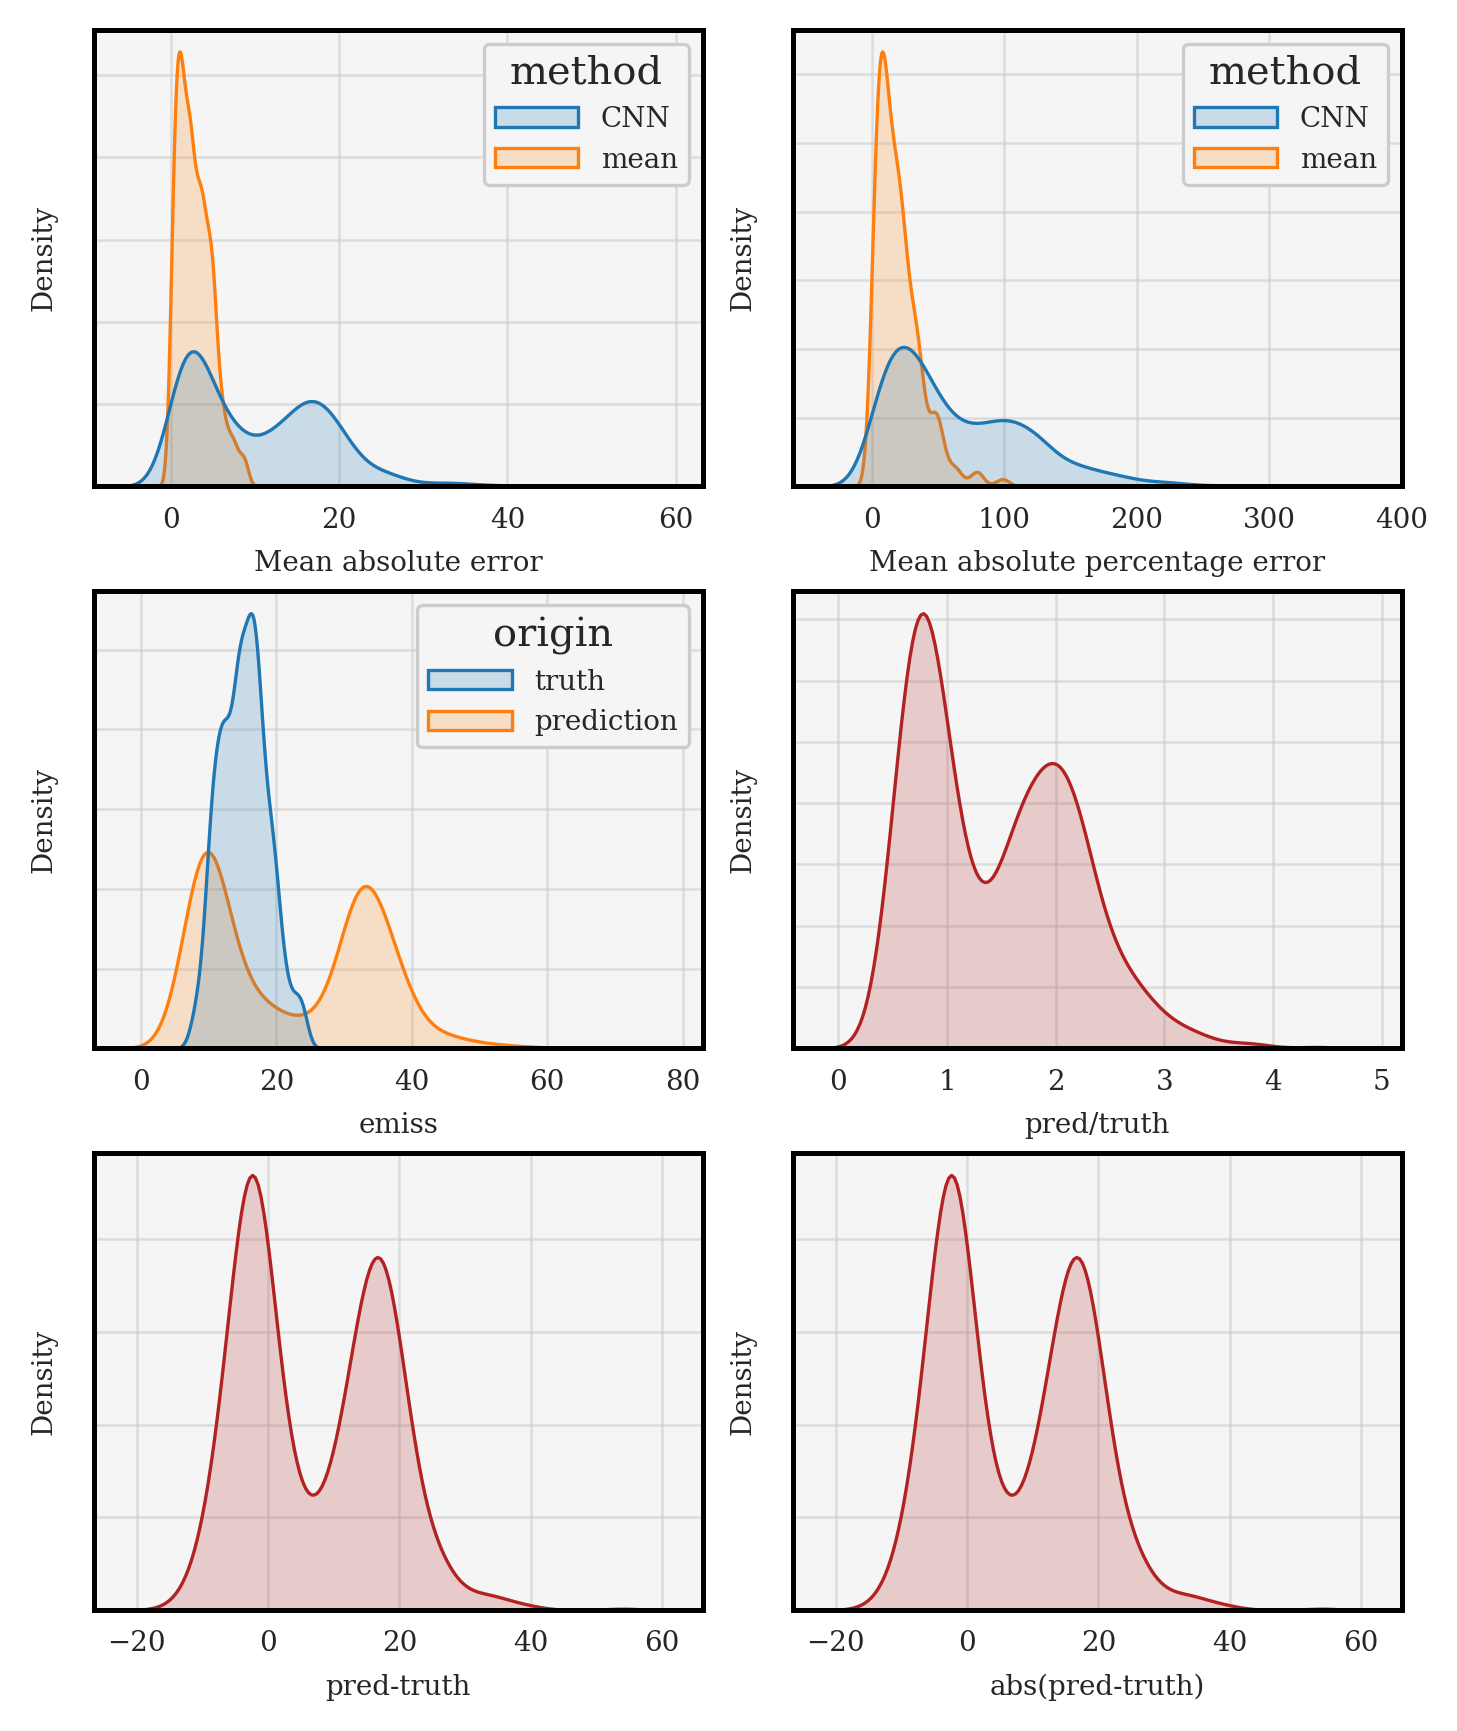

In [10]:
model_eval.get_summary_histo_inversion(model, data)

nwbce: tf.Tensor(2.472952, shape=(), dtype=float32)
idx 364
origin: smart_2km_Lip_64
time: 2015-04-22T04:00:00.000000000
emiss: [11.87363 11.39118 11.5513  11.55119 12.67409 14.11787]
nwbce: tf.Tensor(21.058315, shape=(), dtype=float32)
idx 1008
origin: smart_2km_Lip_64
time: 2015-11-21T00:00:00.000000000
emiss: [11.1307  14.72988 16.06919 16.90651 17.07405 17.07426]
nwbce: tf.Tensor(5.4711037, shape=(), dtype=float32)
idx 127
origin: smart_2km_Lip_64
time: 2015-02-07T07:00:00.000000000
emiss: [17.73385 15.1072  13.13578 12.14942 11.65661 11.82066]
1/1 [==============================] - 0s 25ms/step


<Figure size 1920x1440 with 0 Axes>

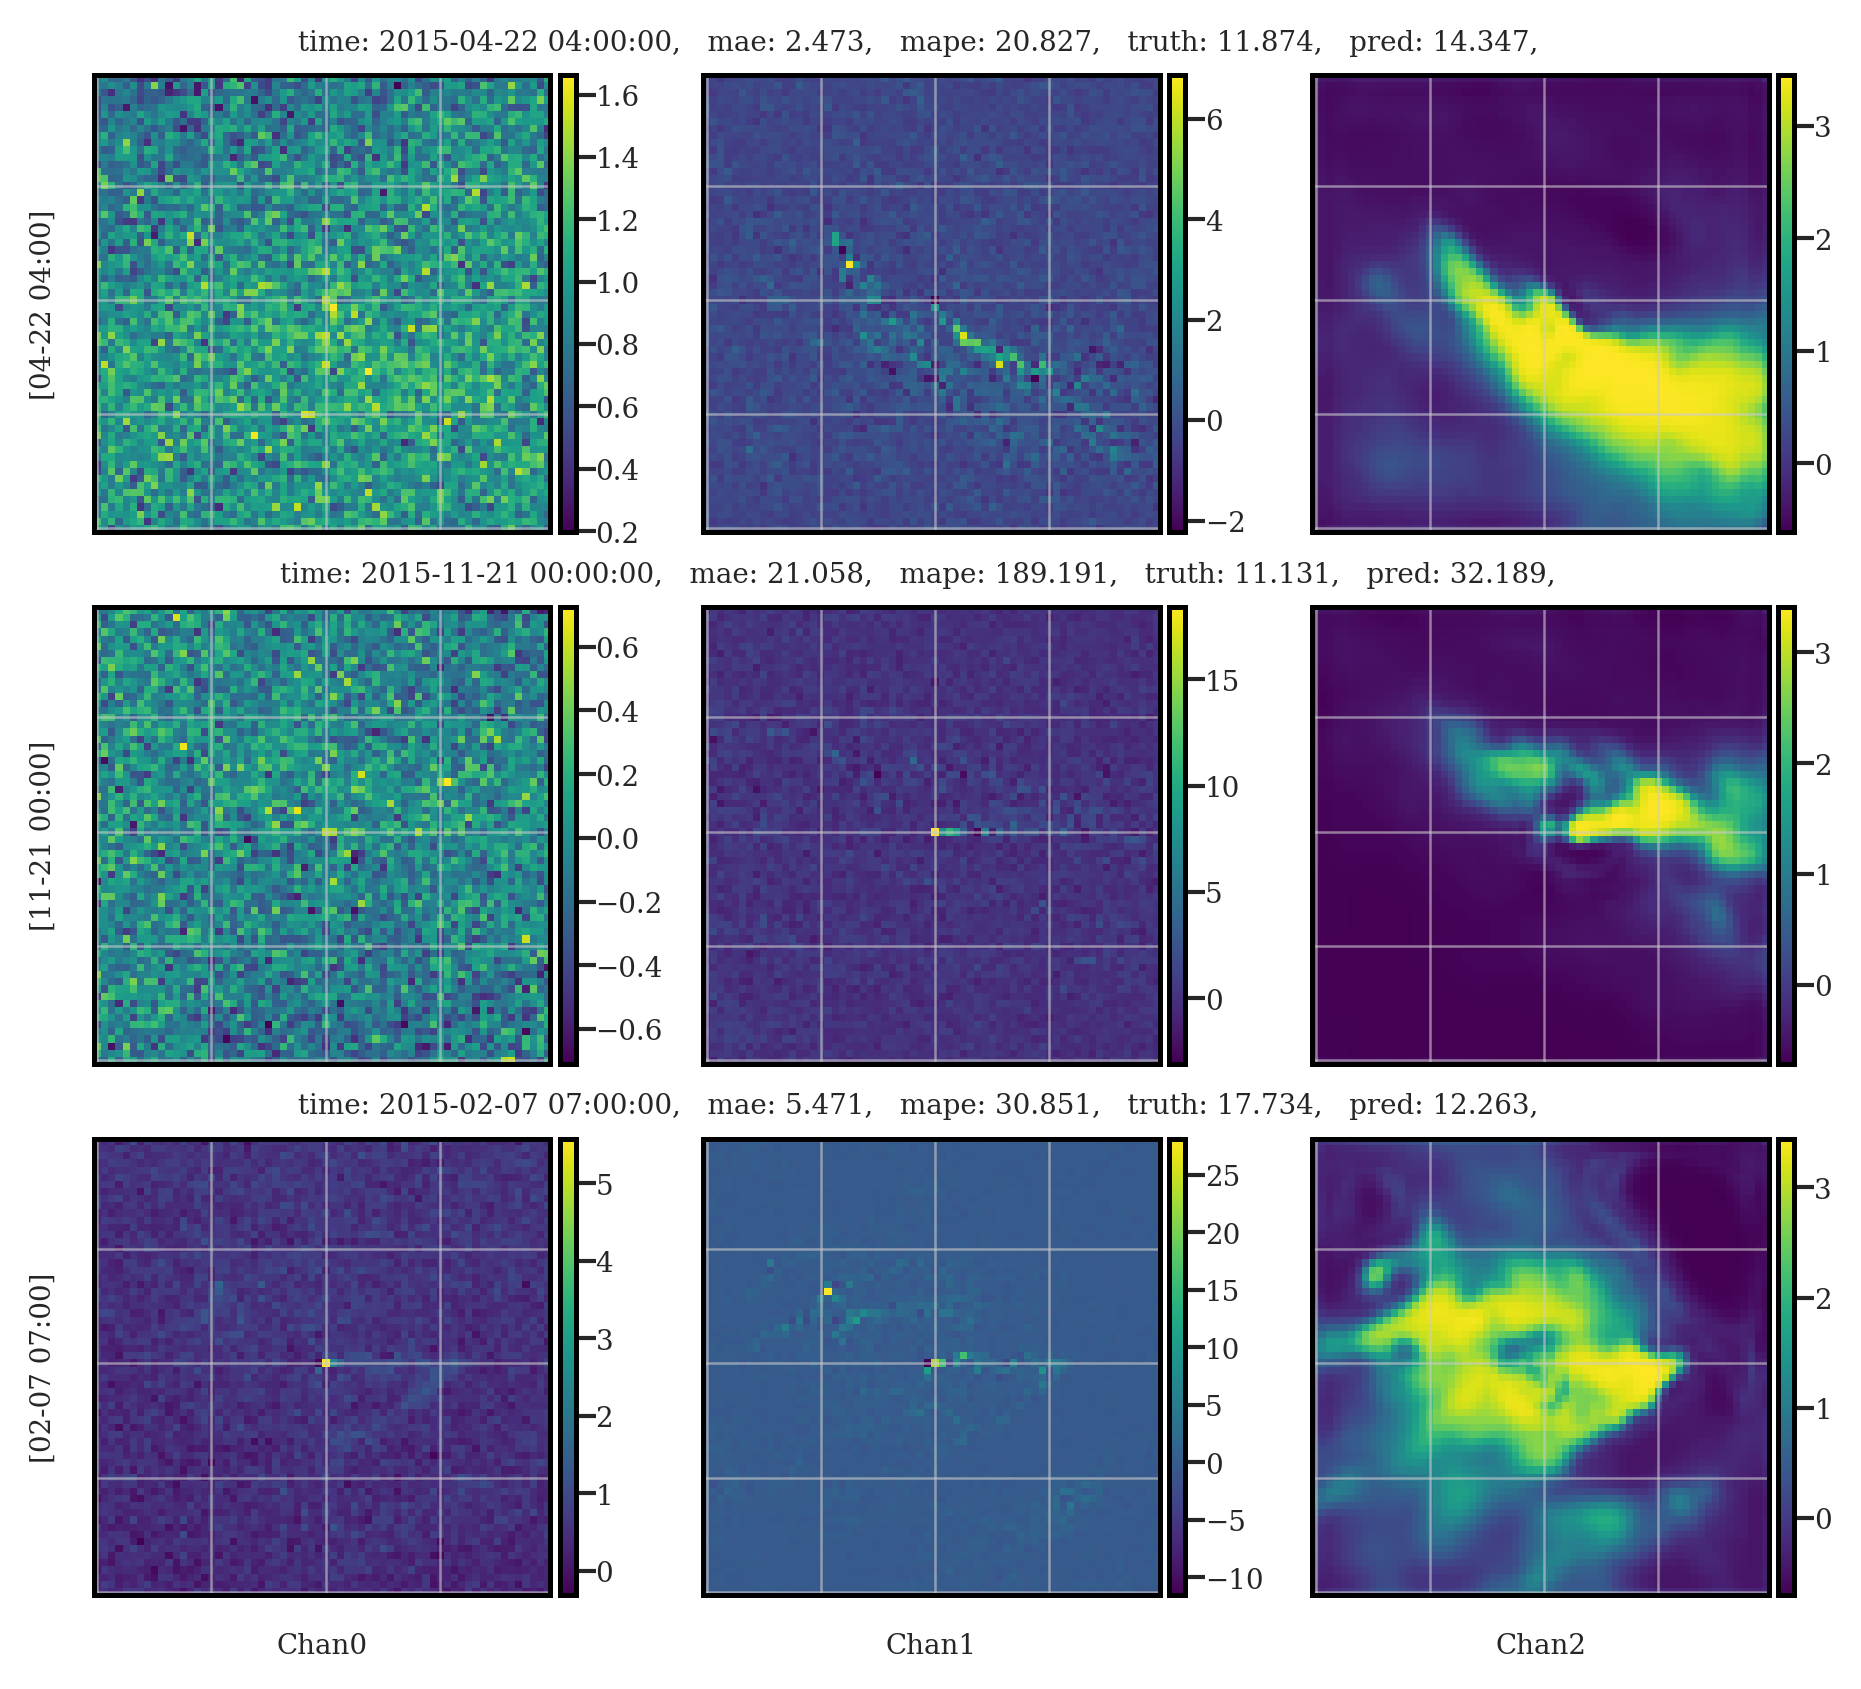

In [11]:
model_eval.plot_inversion_examples(data, metrics["mae"], metrics["mape"], model)